## Image Captioning
- generating captions for images

## Steps 
- data collection 
- understanding the data
- data cleaning 
- loading the data 
- data preprocessing--images
- data preprocessing--captions
- data preparation using generator function
- word embeddings
- model architecture
- inference
- evaluation


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from tensorflow.keras.layers import *

In [2]:
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [3]:
captions = readTextFile(r"C:\Users\91878\1_PYTHON_ONE\Capstone Project\Flick_TextData\Flickr8k.token.txt")
captions = captions.split("\n")[:-1]

In [4]:
print(captions[1].split('\t'))
print(len(captions))

['1000268201_693b08cb0e.jpg#1', 'A girl going into a wooden building .']
40460


In [5]:
# dictionary to map each image with its captions

In [6]:
first,second = captions[0].split('\t')
print(first.split(".")[0])
print(second)

1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


In [7]:
descriptions = {}

for x in captions:
    first,second = x.split('\t') #second is itself a description of the image
    img_name = first.split('.')[0]
    
    #if the image id is alreasy present or not 
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
         
    descriptions[img_name].append(second)
    

In [8]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

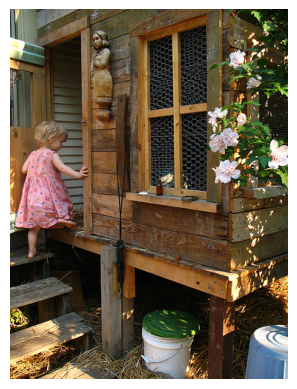

In [9]:
IMG_PATH = r"C:\Users\91878\1_PYTHON_ONE\Capstone Project\images"
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(IMG_PATH+"\\"+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()

## Data cleaning

In [10]:
import re

In [11]:
 def clean_text(sentence):
        sentence = sentence.lower()
        sentence = re.sub("[^a-z]+"," ",sentence)
        sentence = sentence.split()
        
        sentence = [s for s in sentence if len(s)>1]
        sentence = " ".join(sentence)
        return sentence

In [12]:
clean_text("A cat is sitting over the house number 64")

'cat is sitting over the house number'

In [13]:
# clean all the captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [14]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [15]:
# write the data to text file

with open('descriptions.text','w') as f:
    f.write(str(descriptions))

## Create a vocabulary

In [16]:
import json

In [17]:
descriptions = None 
with open ('descriptions.text','r') as f:
    descriptions = f.read()
    
json_accetable_string = descriptions.replace("'","\"")
descriptions = json.loads(json_accetable_string)

In [18]:
print(type(descriptions))

<class 'dict'>


In [19]:
descriptions["2513260012_03d33305cf"]

['black dog is running after white dog in the snow',
 'black dog chasing brown dog through snow',
 'two dogs chase each other across the snowy ground',
 'two dogs play together in the snow',
 'two dogs running through low lying body of water']

In [20]:
vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]

print("Vocab Size :%d"%len(vocab))

Vocab Size :8424


In [21]:
# vocab = set()
# vocab.update(["hello"])
# vocab.update(["hi"])
# vocab.update(["hello"])
# print(vocab)

In [22]:
# Total no of words across all the sentences
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    

print("Vocab Words :%d"%len(total_words))

Vocab Words :373837


In [23]:
print(total_words[:10])

['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs']


In [24]:
# now we have to keep the most frequent words and delete the unused vocab
# filter the words from the vocab according to certain threshold frequency

In [25]:
import collections 

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
#print(freq_cnt)

In [26]:
print(len(freq_cnt.keys()))

8424


In [27]:
# sort this dictionary to the freq count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

threshold = 10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [28]:
total_words

['in',
 'the',
 'on',
 'is',
 'and',
 'dog',
 'with',
 'man',
 'of',
 'two',
 'white',
 'black',
 'boy',
 'are',
 'woman',
 'girl',
 'to',
 'wearing',
 'at',
 'people',
 'water',
 'red',
 'young',
 'brown',
 'an',
 'his',
 'blue',
 'dogs',
 'running',
 'through',
 'playing',
 'while',
 'shirt',
 'down',
 'standing',
 'ball',
 'little',
 'grass',
 'snow',
 'child',
 'person',
 'jumping',
 'over',
 'three',
 'front',
 'sitting',
 'holding',
 'up',
 'field',
 'small',
 'by',
 'large',
 'green',
 'one',
 'group',
 'yellow',
 'her',
 'walking',
 'children',
 'men',
 'into',
 'air',
 'beach',
 'near',
 'mouth',
 'jumps',
 'another',
 'for',
 'street',
 'runs',
 'its',
 'from',
 'riding',
 'stands',
 'as',
 'bike',
 'girls',
 'outside',
 'other',
 'off',
 'out',
 'rock',
 'next',
 'play',
 'orange',
 'looking',
 'pink',
 'player',
 'camera',
 'their',
 'pool',
 'hat',
 'jacket',
 'boys',
 'women',
 'around',
 'behind',
 'some',
 'background',
 'dirt',
 'toy',
 'soccer',
 'sits',
 'dressed',
 

In [29]:
print(len(total_words))

1845


### Prepare train/test data

In [30]:
train_file_data = readTextFile(r"C:\Users\91878\1_PYTHON_ONE\Capstone Project\Flick_TextData\Flickr_8k.trainImages.txt")

In [31]:
test_file_data = readTextFile(r"C:\Users\91878\1_PYTHON_ONE\Capstone Project\Flick_TextData\Flickr_8k.testImages.txt")

In [32]:
#print(train_file_data)

In [33]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
print(train)

['2513260012_03d33305cf', '2903617548_d3e38d7f88', '3338291921_fe7ae0c8f8', '488416045_1c6d903fe0', '2644326817_8f45080b87', '218342358_1755a9cce1', '2501968935_02f2cd8079', '2699342860_5288e203ea', '2638369467_8fc251595b', '2926786902_815a99a154', '2851304910_b5721199bc', '3423802527_94bd2b23b0', '3356369156_074750c6cc', '2294598473_40637b5c04', '1191338263_a4fa073154', '2380765956_6313d8cae3', '3197891333_b1b0fd1702', '3119887967_271a097464', '2276499757_b44dc6f8ce', '2506892928_7e79bec613', '2187222896_c206d63396', '2826769554_85c90864c9', '3097196395_ec06075389', '3603116579_4a28a932e2', '3339263085_6db9fd0981', '2532262109_87429a2cae', '2076906555_c20dc082db', '2502007071_82a8c639cf', '3113769557_9edbb8275c', '3325974730_3ee192e4ff', '1655781989_b15ab4cbff', '1662261486_db967930de', '2410562803_56ec09f41c', '2469498117_b4543e1460', '69710415_5c2bfb1058', '3414734842_beb543f400', '3006217970_90b42e6b27', '2192411521_9c7e488c5e', '3535879138_9281dc83d5', '2685788323_ceab14534a', '34

In [34]:
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]
print(test[:5])

['3385593926_d3e9c21170', '2677656448_6b7e7702af', '311146855_0b65fdb169', '1258913059_07c613f7ff', '241347760_d44c8d3a01']


In [35]:
# prepare the description for the training data
# Tweak - Add <s> and <e> taken to our training data
# start and end tokens are added to the words to signify when to actually stop the text generation 

In [36]:
train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq " +cap+ " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [37]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

### Transfer Learning
- images -> features
- test -> features

### Step-1 image feature extraction

In [38]:
from tensorflow.keras.applications.resnet50 import ResNet50,preprocess_input
from keras import  Model
import numpy as np

In [39]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [40]:
model.layers[-2].output

<KerasTensor: shape=(None, 2048) dtype=float32 (created by layer 'avg_pool')>

In [41]:
model_new = Model(model.input,model.layers[-2].output)

#### The resnet model's layers are basically used for the feature extraction of the images of the 
#### captions. This vector obtained from this model will be fed into the img_caption model

In [42]:
from tensorflow.keras.preprocessing import image

In [43]:
def preprocessing_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0) #This is used to convert 224x224x3 to 1x224x224x3
    # Normalisation 
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


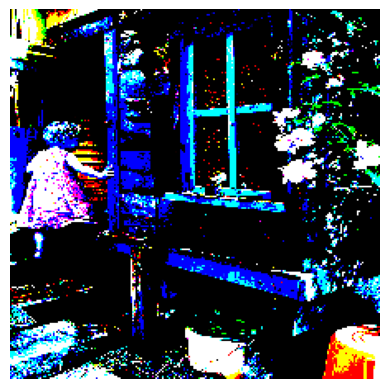

In [44]:
img = preprocessing_img(IMG_PATH+"\\"+"1000268201_693b08cb0e.jpg")
plt.imshow(img[0]) # it is a 4D tensor
plt.axis('off')
plt.show()

In [45]:
# from 2-axis we need to have images into 1-axis

def encode_img(img):
    img = preprocessing_img(img)
    feature_vector = model_new.predict(img)
    #print(feature_vector.shape)
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [46]:
encode_img(IMG_PATH+"\\"+"1000268201_693b08cb0e.jpg")

1/1 [==============================] - 1s 993ms/step


array([0.0653655 , 0.16782689, 0.3251846 , ..., 0.0511154 , 0.32817933,
       1.0043333 ], dtype=float32)

In [47]:
import time
import pickle

In [48]:
start = time.time()
encoding_train = {}
# image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(train):
    img_path = IMG_PATH+'\\'+img_id+'.jpg'
    encoding_train[img_id] = encode_img(img_path)
    
    if ix%100==0:
        print("Encoding in Progress TimeStep %d"%ix)
        
    
end = time.time()
print("Total time taken :",end-start)

1/1 [==============================] - 0s 125ms/step
Encoding in Progress TimeStep 0
1/1 [==============================] - 0s 109ms/step
Encoding in Progress TimeStep 100
1/1 [==============================] - 0s 106ms/step


1/1 [==============================] - 0s 104ms/step
Encoding in Progress TimeStep 200
1/1 [==============================] - 0s 105ms/step
Encoding in Progress TimeStep 300
1/1 [==============================] - 0s 100ms/step


1/1 [==============================] - 0s 110ms/step
Encoding in Progress TimeStep 400
1/1 [==============================] - 0s 100ms/step


1/1 [==============================] - 0s 101ms/step
Encoding in Progress TimeStep 500
1/1 [==============================] - 0s 105ms/step
Encoding in Progress TimeStep 600
1/1 [==============================] - 0s 102ms/step


1/1 [==============================] - 0s 106ms/step
Encoding in Progress TimeStep 700
1/1 [==============================] - 0s 100ms/step


1/1 [==============================] - 0s 106ms/step
Encoding in Progress TimeStep 800
1/1 [==============================] - 0s 110ms/step
Encoding in Progress TimeStep 900
1/1 [==============================] - 0s 110ms/step


1/1 [==============================] - 0s 105ms/step
Encoding in Progress TimeStep 1000
1/1 [==============================] - 0s 105ms/step


1/1 [==============================] - 0s 110ms/step
Encoding in Progress TimeStep 1100
1/1 [==============================] - 0s 110ms/step
Encoding in Progress TimeStep 1200
1/1 [==============================] - 0s 120ms/step


1/1 [==============================] - 0s 130ms/step
Encoding in Progress TimeStep 1300
1/1 [==============================] - 0s 156ms/step


1/1 [==============================] - 0s 140ms/step
Encoding in Progress TimeStep 1400
1/1 [==============================] - 0s 129ms/step
Encoding in Progress TimeStep 1500
1/1 [==============================] - 0s 136ms/step


1/1 [==============================] - 0s 129ms/step
Encoding in Progress TimeStep 1600
1/1 [==============================] - 0s 110ms/step


1/1 [==============================] - 0s 123ms/step
Encoding in Progress TimeStep 1700
1/1 [==============================] - 0s 145ms/step
Encoding in Progress TimeStep 1800
1/1 [==============================] - 0s 127ms/step


1/1 [==============================] - 0s 149ms/step
Encoding in Progress TimeStep 1900
1/1 [==============================] - 0s 170ms/step


1/1 [==============================] - 0s 130ms/step
Encoding in Progress TimeStep 2000
1/1 [==============================] - 0s 120ms/step
Encoding in Progress TimeStep 2100
1/1 [==============================] - 0s 128ms/step


1/1 [==============================] - 0s 125ms/step
Encoding in Progress TimeStep 2200
1/1 [==============================] - 0s 120ms/step
Encoding in Progress TimeStep 2300
1/1 [==============================] - 0s 129ms/step


1/1 [==============================] - 0s 125ms/step
Encoding in Progress TimeStep 2400
1/1 [==============================] - 0s 126ms/step


1/1 [==============================] - 0s 126ms/step
Encoding in Progress TimeStep 2500
1/1 [==============================] - 0s 130ms/step
Encoding in Progress TimeStep 2600
1/1 [==============================] - 0s 131ms/step


1/1 [==============================] - 0s 130ms/step
Encoding in Progress TimeStep 2700
1/1 [==============================] - 0s 130ms/step


1/1 [==============================] - 0s 133ms/step
Encoding in Progress TimeStep 2800
1/1 [==============================] - 0s 138ms/step
Encoding in Progress TimeStep 2900
1/1 [==============================] - 0s 150ms/step


1/1 [==============================] - 0s 129ms/step
Encoding in Progress TimeStep 3000
1/1 [==============================] - 0s 120ms/step


1/1 [==============================] - 0s 143ms/step
Encoding in Progress TimeStep 3100
1/1 [==============================] - 0s 115ms/step
Encoding in Progress TimeStep 3200
1/1 [==============================] - 0s 125ms/step


1/1 [==============================] - 0s 185ms/step
Encoding in Progress TimeStep 3300
1/1 [==============================] - 0s 151ms/step


1/1 [==============================] - 0s 144ms/step
Encoding in Progress TimeStep 3400
1/1 [==============================] - 0s 126ms/step
Encoding in Progress TimeStep 3500
1/1 [==============================] - 0s 157ms/step


1/1 [==============================] - 0s 140ms/step
Encoding in Progress TimeStep 3600
1/1 [==============================] - 0s 138ms/step


1/1 [==============================] - 0s 153ms/step
Encoding in Progress TimeStep 3700
1/1 [==============================] - 0s 140ms/step
Encoding in Progress TimeStep 3800
1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 132ms/step
Encoding in Progress TimeStep 3900
1/1 [==============================] - 0s 142ms/step


1/1 [==============================] - 0s 226ms/step
Encoding in Progress TimeStep 4000
1/1 [==============================] - 0s 135ms/step
Encoding in Progress TimeStep 4100
1/1 [==============================] - 0s 167ms/step


1/1 [==============================] - 0s 149ms/step
Encoding in Progress TimeStep 4200
1/1 [==============================] - 0s 174ms/step


1/1 [==============================] - 0s 174ms/step
Encoding in Progress TimeStep 4300
1/1 [==============================] - 0s 159ms/step
Encoding in Progress TimeStep 4400
1/1 [==============================] - 0s 144ms/step


1/1 [==============================] - 0s 149ms/step
Encoding in Progress TimeStep 4500
1/1 [==============================] - 0s 142ms/step
Encoding in Progress TimeStep 4600
1/1 [==============================] - 0s 169ms/step


1/1 [==============================] - 0s 171ms/step
Encoding in Progress TimeStep 4700
1/1 [==============================] - 0s 144ms/step


1/1 [==============================] - 0s 148ms/step
Encoding in Progress TimeStep 4800
1/1 [==============================] - 0s 155ms/step
Encoding in Progress TimeStep 4900
1/1 [==============================] - 0s 175ms/step


1/1 [==============================] - 0s 158ms/step
Encoding in Progress TimeStep 5000
1/1 [==============================] - 0s 152ms/step


1/1 [==============================] - 0s 170ms/step
Encoding in Progress TimeStep 5100
1/1 [==============================] - 0s 160ms/step
Encoding in Progress TimeStep 5200
1/1 [==============================] - 0s 151ms/step


1/1 [==============================] - 0s 158ms/step
Encoding in Progress TimeStep 5300
1/1 [==============================] - 0s 154ms/step


1/1 [==============================] - 0s 174ms/step
Encoding in Progress TimeStep 5400
1/1 [==============================] - 0s 165ms/step
Encoding in Progress TimeStep 5500
1/1 [==============================] - 0s 159ms/step


1/1 [==============================] - 0s 179ms/step
Encoding in Progress TimeStep 5600
1/1 [==============================] - 0s 156ms/step


1/1 [==============================] - 0s 158ms/step
Encoding in Progress TimeStep 5700
1/1 [==============================] - 0s 162ms/step
Encoding in Progress TimeStep 5800
1/1 [==============================] - 0s 160ms/step


1/1 [==============================] - 0s 175ms/step
Encoding in Progress TimeStep 5900
1/1 [==============================] - 0s 159ms/step


1/1 [==============================] - 0s 149ms/step
Total time taken : 1146.2384433746338


In [49]:
# Store everything to the disk //
## Pickle is used to store any thing on the ram into a file format which can be accessed later
## Pickle .load and .dump

In [50]:
with open("encoded_train_features.pkl",'wb') as f:
    pickle.dump(encoding_train,f)
    

In [51]:
start = time.time()
encoding_test = {}
# image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+'\\'+img_id+'.jpg'
    encoding_test[img_id] = encode_img(img_path)
    
    if ix%100==0:
        print("Encoding in Progress TimeStep %d"%ix)
        
    
end = time.time()
print("Total time taken :",end-start)

1/1 [==============================] - 0s 170ms/step
Encoding in Progress TimeStep 0
1/1 [==============================] - 0s 162ms/step
Encoding in Progress TimeStep 100
1/1 [==============================] - 0s 152ms/step


1/1 [==============================] - 0s 156ms/step
Encoding in Progress TimeStep 200
1/1 [==============================] - 0s 164ms/step
Encoding in Progress TimeStep 300
1/1 [==============================] - 0s 164ms/step


1/1 [==============================] - 0s 152ms/step
Encoding in Progress TimeStep 400
1/1 [==============================] - 0s 192ms/step


1/1 [==============================] - 0s 172ms/step
Encoding in Progress TimeStep 500
1/1 [==============================] - 0s 166ms/step
Encoding in Progress TimeStep 600
1/1 [==============================] - 0s 186ms/step


1/1 [==============================] - 0s 335ms/step
Encoding in Progress TimeStep 700
1/1 [==============================] - 0s 165ms/step


1/1 [==============================] - 0s 161ms/step
Encoding in Progress TimeStep 800
1/1 [==============================] - 0s 197ms/step
Encoding in Progress TimeStep 900
1/1 [==============================] - 0s 180ms/step


1/1 [==============================] - 0s 215ms/step
Total time taken : 245.26543879508972


In [52]:
with open("encoded_test_features.pkl",'wb') as f:
    pickle.dump(encoding_test,f)

### Data preprocessing for captions

In [53]:
# Vocab
len(total_words)

1845

In [54]:
word_to_idx = {}
idx_to_word = {}
for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [55]:
print(word_to_idx['dog'])
print(idx_to_word[6])
print(len(idx_to_word))

6
dog
1845


In [56]:
# we have to add <s> and <e>
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847


vocab_size = len(word_to_idx)+1
print(vocab_size)

1848


In [57]:
max_Len = 0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_Len = max(max_Len,len(cap.split()))
        
print(max_Len)

35


In [58]:
with open(r"C:\Users\91878\1_PYTHON_ONE\Integrating ML model with flask\Image Captioning\word_to_idx.pkl"
          ,"wb") as w2i:
    pickle.dump(word_to_idx,w2i)
    
with open(r"C:\Users\91878\1_PYTHON_ONE\Integrating ML model with flask\Image Captioning\idx_to_word.pkl"
          ,"wb") as i2w:
    pickle.dump(idx_to_word,i2w)

## Data Loader(Generator)

ptrobability of generating a word is dependent on the probabilities of the past words

In [328]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key+".jpg"]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorcial([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0

In [329]:
f = open(r"C:\Users\91878\1_PYTHON_ONE\glove.6B.50d.txt",encoding='utf-8')

In [330]:
embedding_index = {}

for line in f:
    values = line.split()
    print(values)
    
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



['andrejew', '-0.52965', '-0.69249', '0.28491', '-0.64271', '-0.56502', '0.044529', '-0.66979', '-0.055318', '-0.32864', '0.30054', '1.14', '0.27796', '0.2003', '0.19274', '-0.19344', '-0.040847', '0.35487', '-0.23713', '0.64877', '-0.17405', '-0.022425', '-0.13529', '-0.39058', '0.057492', '1.193', '1.9192', '0.78524', '0.08174', '0.18612', '0.50357', '-0.88731', '-0.16807', '0.85346', '-0.59908', '-0.42489', '0.45528', '0.094853', '0.16825', '-0.13274', '0.80543', '0.13195', '-0.24373', '-0.26747', '-1.147', '-0.13365', '-0.71898', '0.32814', '0.42491', '0.55695', '0.25399']
['gustas', '-1.6276', '0.20355', '0.52032', '-0.53312', '0.46235', '-0.8296', '-0.088235', '0.034954', '0.025835', '0.042657', '-0.60433', '0.4388', '0.83694', '-1.0077', '-0.28528', '0.32332', '0.1648', '0.28563', '0.67639', '0.78714', '-0.34163', '0.90986', '0.22639', '0.63918', '1.1629', '0.29822', '-0.091678', '-0.073677', '1.6151', '-0.64151', '-1.7986', '0.38172', '0.40995', '0.67576', '-0.027117', '-0.3610

In [331]:
f.close()

In [332]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [333]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [334]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [335]:
embedding_matrix[1847] # start and end sequnce is not present in the glove matrix  

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Model Architecture

In [336]:
from tensorflow.keras import Input
from tensorflow.keras.layers import *

In [337]:
# to process images

input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.5)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [338]:
# Captions as input 
input_captions = Input(shape=(max_Len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [339]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)


# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [340]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 35)]         0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 35, 50)       92400       ['input_15[0][0]']               
                                                                                                  
 dropout_6 (Dropout)            (None, 2048)         0           ['input_14[0][0]']               
                                                                                            

In [341]:
# Important ZThing - Embedding_layer

model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [342]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

### Traing of Model

In [343]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size

In [344]:
def train():
     for i in range(epochs):
            generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_Len,batch_size)
            model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
            model.save('./model_weights/model_'+str(i)+'.h5')

In [345]:
#model = load_model('./model_weighta/model_9.h5')

OSError: No file or directory found at ./model_weighta/model_9.h5

In [346]:
for i in range(epochs):
    generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_Len,batch_size)
    model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
    model.save('./model_weights/model_'+str(i)+'.h5')

C:\Users\91878\AppData\Local\Temp\ipykernel_11484\3348117097.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)


KeyError: '2513260012_03d33305cf.jpg'

In [ ]:
model = load_model('./model_weighta/model_9.h5')